## Implementing Multifidelity Modeling with GPy Package using NARGP

In [5]:
import GPy
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(42)

Function Definitions

In [6]:
def high(x):
    return (x-np.sqrt(2))*low(x)**2

def low(x):
    return np.sin(8.0*np.pi*x)

def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [7]:
# Define input points
N1 = 50   # number of Low fidelity points
N2 = 14   # number of High Fidelity Points

Ntest = 400
X_test = np.linspace(0,1,Ntest)[:,None]
Exact = high(X_test)
Low = low(X_test)

X1 = np.linspace(0,1,N1)[:,None]
D2 = np.random.permutation(N1)
X2 = X1[D2[0:N2]]

Y1 = low(X1)
Y2 = high(X2)

In [9]:
# Train the low fidelity
kernel1 = GPy.kern.RBF(1)
m1 = GPy.models.GPRegression(X=X1, Y=Y1, kernel=kernel1)

m1[".*Gaussian_noise"] = m1.Y.var()*0.01
m1[".*Gaussian_noise"].fix()

m1.optimize(max_iters = 500)

m1[".*Gaussian_noise"].unfix()
m1[".*Gaussian_noise"].constrain_positive()

# Restart optimization to find the global minimum instead of a local one
m1.optimize_restarts(20, optimizer = "bfgs",  max_iters = 1000)

mu1, v1 = m1.predict(X2)

reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/20, f = -235.71266028395289
Optimization restart 2/20, f = 53.11317955739817
Optimization restart 3/20, f = 53.11318563062365
Optimization restart 4/20, f = 53.11318711494337
Optimization restart 5/20, f = 53.11318347903459
Optimization restart 6/20, f = 53.11317955369624
Optimization restart 7/20, f = 53.11318706663796
Optimization restart 8/20, f = -235.71266302435126
Optimization restart 9/20, f = 53.113179746020585
Optimization restart 10/20, f = 53.11320037474275
Optimization restart 11/20, f = 53.11318626701906
Optimization restart 12/20, f = 53.11318580038986
Optimization restart 13/20, f = 53.113182351252675
Optimization restart 14/20, f = 53.11318018832648
Optimization restart 15/20, f = 53.11325714233672
Optimization restart 16/20, f = 53.113205840451904
Optimization restart 17/20, f = 53.1131799757775
Optimization restart 18/20, f = 53.11318422779457
Optimization restart 19/20, f = 53.11317953034924
Optimization restart 20/20, f = 53.11318005702748


In [17]:
# Train the higher fidelity
XX = np.hstack((X2,mu1))

# Kernel in NARGP by Perdikaris, P.
kernel2 = GPy.kern.RBF(1, active_dims = [1])*GPy.kern.RBF(1, active_dims = [0]) \
             + GPy.kern.RBF(1, active_dims = [0])

m2 = GPy.models.GPRegression(X=XX, Y=Y2, kernel=kernel2)

m2[".*Gaussian_noise"] = m2.Y.var()*0.01
m2[".*Gaussian_noise"].fix()

m2.optimize(max_iters = 500)

m2[".*Gaussian_noise"].unfix()
m2[".*Gaussian_noise"].constrain_positive()

# Restart optimization to find the global minimum instead of a local one
m2.optimize_restarts(20, optimizer = "bfgs",  max_iters = 1000)

reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/20, f = -15.739871413413617
Optimization restart 2/20, f = -15.739871149026428
Optimization restart 3/20, f = -15.739870132856822
Optimization restart 4/20, f = -15.739870289840749
Optimization restart 5/20, f = -15.73987082651805
Optimization restart 6/20, f = -15.739870258953557
Optimization restart 7/20, f = -15.73986969306879
Optimization restart 8/20, f = 4.8276556920874505
Optimization restart 9/20, f = -15.739871134069395
Optimization restart 10/20, f = -15.739870185915457
Optimization restart 11/20, f = -15.739871063015261
Optimization restart 12/20, f = -15.739871147021969
Optimization restart 13/20, f = -15.739870731287276
Optimization restart 14/20, f = -15.739869974227636
Optimization restart 15/20, f = -15.739869497885781
Optimization restart 16/20, f = -15.739871069805188
Optimization restart 17/20, f = -15.739870454558398
Optimization restart 18/20, f = 4.782710214715131
Optimization restart 19/20, f = -15.739870683723867
Optimization restart 20/20

In [34]:
# Test Cases
nsamples = 1000   # Number of samples to be drawn
mu1, C1 = m1.predict(X_test,full_cov=True)
Z1 = np.random.multivariate_normal(mu1.flatten(), C1 , size=nsamples)


In [45]:
tmp_mean = np.zeros((nsamples,Ntest))
tmp_var  = np.zeros((nsamples,Ntest))

for i in range(0,nsamples):
    # Draw samples from posterior of low fidelity and use it 
    # as the input for the higher fidelity  (Monte Carlo Integration)
    mu, var = m2.predict(np.hstack((X_test, Z1[i,:][:,None])))
    
    tmp_mean[i,:] = mu.flatten()
    tmp_var[i,:]  = var.flatten()

In [46]:
# Get the posterior mean and the variance
mean = np.mean(tmp_mean, axis = 0)[:,None]
var  = np.mean(tmp_var, axis = 0)[:,None] + np.var(tmp_mean, axis = 0)[:,None]
var = np.abs(var)

In [49]:
# Performance
error = np.linalg.norm(Exact - mean) / np.linalg.norm(Exact)
print ("Error = {}".format(error))

Error = 0.010601696902797499


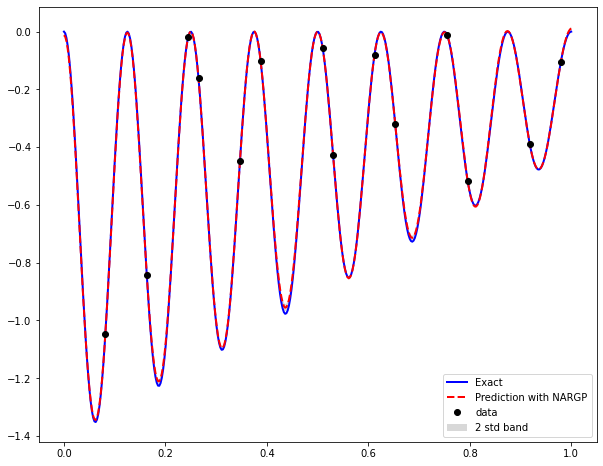

In [61]:
# Plotting
lower_bound = mean - 2.0*np.sqrt(var)
upper_bound = mean + 2.0*np.sqrt(var)

plt.figure(1, figsize=(10,8))
plt.plot(X_test,Exact, 'b', label = "Exact", linewidth=2)
plt.plot(X_test,mean, 'r--', label = "Prediction with NARGP", linewidth=2)
# plt.plot(X_test, mean + 2.0*np.sqrt(var), 'g:')
# plt.plot(X_test, mean - 2.0*np.sqrt(var), 'g:')
plt.gca().fill_between(X_test.flatten(), lower_bound.flatten(), upper_bound.flatten(),
                       facecolor='gray', alpha=0.3, label="2 std band")
plt.plot(X2,Y2,'ko',label='data')
plt.legend()